## CHEME 5660: Does Markowitz portfolio allocation perform better than alternative approaches?

### Introduction
In this lab, let's explore a thought experiment. Suppose we took two years of OHLC data for a bunch of tickers and split this data into training and prediction batches. Using the training data, we'll construct Markowitz portfolios. We’ll test the Markowitz portfolios on the prediction branch against various alternative approaches (including a custom allocation you build). In particular, we'll calculate the future wealth that is generated by each portfolio. 

Let the best portfolio win!

### Lab 7 setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-7-Markowitz-Portfolio-Allocation`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-7-Markowitz-Portfolio-Allocation/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-7-Markowitz-Portfolio-Allocation/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using Dates
using Colors
using Plots
using StatsPlots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("CHEME-5660-Lab-7-CodeLib.jl");

#### Set constants for Lab 7

In [18]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# setup daily margin rate -
b̂ = 0.065;
margin_rate_daily = ((1+b̂)^(1/365) - 1);

# What is our initial wealth?
Wₒ = 10000.0; # units: USD

# how many days of historical data are we using?
m̂ = 299; # you get to choose this
λ̂ = 0.001; # you get to choose this: Boltzmann weighting factor λ̂ = 0.0 gives unweigted

### Lab 7 calculations

#### Load and process the OHLC data set
In the following code block we:
* Exclude tickers from the data that don't have the same length as the market ticker `SPY`.
* Define (and sort) the ticker array (holds an ordered list of ticker symbols potentially in our portfolio)
* Partition the OHLC data into training and prediction data sets

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = clean(load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"]);

# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many ticker symbols do we have?
Nₐ = length(ticker_symbol_array);

# Partition the data into a training and prediction set
(price_training_dict, price_prediction_dict) = partition(price_data_dictionary, (m̂+1));

Length violation: META was removed; dim(SPY) = 597 days and dim(META) = 247 days
Length violation: BIIB was removed; dim(SPY) = 597 days and dim(BIIB) = 596 days


#### Estimate Single Index Models (SIMs) for each of the assets in the training set

In [6]:
# build the set of single index models using the *training* set -
sim_model_dictionary = build(price_training_dict, ticker_symbol_array; 
    m̂ = m̂, λ̂ = λ̂, rf = risk_free_daily);

# compute the excess market return for SPY (in the training data set)
(Rₘ, R̂ₘ, W, μᵦ, pᵦ) = compute_excess_return(price_training_dict["SPY"]; 
    m = m̂, rf = risk_free_daily, λ = λ̂);

# compute the μ_vector -
μ_vector = μ(sim_model_dictionary, R̂ₘ, ticker_symbol_array);

# compute Σ -
Σ_array = Σ(sim_model_dictionary, R̂ₘ, ticker_symbol_array);

#### Compute the Markowitz Allocation for Risky and Risky + Risk-free assets

In [7]:
# define the returns that we are going to simulate -
target_return_array = 100 .*range(0.0, step=0.0001, stop = 0.004) |> collect # percentage
L = length(target_return_array);

#### Case I: Risky assets only (open the cell to see what is going on ... or trust me)
This code block will solve the Markowitz problem for risky assets only for the returns in the `target_return_array`. The Markowitz solutions are collected in the `MinVarArray` array:
* `MinVarArray` is a L x N array where each row is a solution
* `column 1` holds the risk
* `column 2` holds the return value
* `column 3 ... N` hold the allocation values for that solution

In [8]:
# Initialize MinVar array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarArray = Array{Float64,2}(undef,L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation(μ_vector, Σ_array, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        MinVarArray[i,1] = sqrt(opt_val);
        MinVarArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarArray[i, 2+a] = ω[a]
        end
    end
end

#### Case II: Risky + A Single Risk Free Asset (open the cell to see what is going on ... or trust me)
This code block will solve the Markowitz problem for risky and risk-free assets for the returns in the `target_return_array`. The Markowitz solutions are collected in the `MinVarRiskFreeArray` array:
* `MinVarRiskFreeArray` is a L x N array where each row is a solution
* `column 1` holds the risk
* `column 2` holds the return value
* `column 3 ... N` hold the allocation values for that solution

In [9]:
# Initialize MinVarRiskFree array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarRiskFreeArray = Array{Float64,2}(undef, L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation_risk_free(μ_vector, Σ_array, tr;
        risk_free_return = risk_free_daily, w_lower =  0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        # capture the risk and reward values -
        MinVarRiskFreeArray[i,1] = sqrt(opt_val);
        MinVarRiskFreeArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarRiskFreeArray[i,2+a] = ω[a]
        end
    end
end

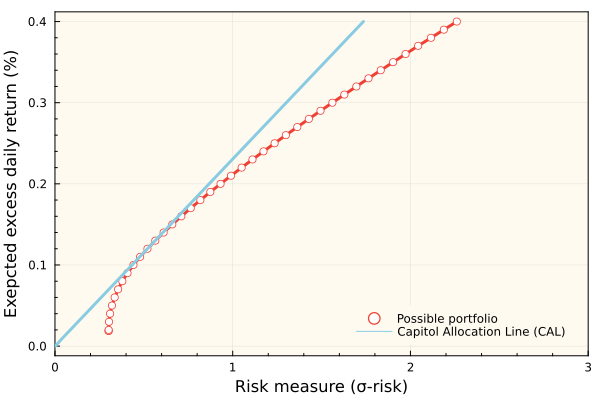

In [10]:
# plot the risk-only portfolio -
plot(MinVarArray[:,1], MinVarArray[:,2], label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, minorticks=0.05, xlim=(0.0,3.0))
scatter!(MinVarArray[:,1], MinVarArray[:,2], label="Possible portfolio", mc=:white, msc=colorant"#EF4035")

# plot the CAL -
plot!(MinVarRiskFreeArray[:,1],  MinVarRiskFreeArray[:,2], lw=3, c=colorant"#89CCE2", label="Capitol Allocation Line (CAL)")

# axis labels -
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted excess daily return (%)", fontsize=18)

### Simulate a portfolio using the prediction data set

#### Which portfolio do you choose?

In [11]:
# make a allocation table for risky+risk free asset case -

# To search the risky only use data_array = MinVarArray
# To search the risky + risky free use data_array = MinVarRiskFreeArray
data_array = MinVarRiskFreeArray;

# select an index to explore -
portfolio_index = index(data_array; σ = 0.5);

# build the table -
allocation_table_data = table(data_array, portfolio_index, Σ_array, μ_vector, ticker_symbol_array; δ = 0.001);

# header -
allocation_table_header = (["Ticker", "weight", "E(r)", "σ"])

# show the table -
pretty_table(allocation_table_data; header = allocation_table_header)

┌────────┬────────────┬─────────────┬──────────┐
│ Ticker │     weight │        E(r) │        σ │
├────────┼────────────┼─────────────┼──────────┤
│   AMGN │  0.0420483 │  0.00725444 │  1.89768 │
│     BA │  0.0185408 │  -0.0145876 │  6.06275 │
│    CLX │  0.0754198 │   0.0743217 │  2.08918 │
│    COP │ 0.00497733 │  -0.0333819 │  5.96709 │
│    CPB │  0.0789591 │   0.0456189 │   1.6202 │
│    CVX │   0.023957 │  -0.0076195 │  3.26127 │
│     ED │ 0.00997105 │ -0.00331326 │  1.24862 │
│    GIS │  0.0520133 │   0.0142483 │  1.23362 │
│   INTC │  0.0538566 │   0.0492051 │  4.21598 │
│      K │   0.054323 │    0.016003 │  1.10956 │
│    KMB │  0.0442205 │   0.0104511 │  1.02788 │
│    LMT │  0.0707505 │   0.0132823 │  1.30786 │
│    MRK │  0.0158648 │ -0.00934799 │  1.00671 │
│    PCG │  0.0448086 │   0.0527386 │   3.6747 │
│      T │  0.0826127 │   0.0252184 │  1.08983 │
│    VXX │   0.162951 │    0.559731 │   12.256 │
│     VZ │  0.0525556 │   0.0019573 │ 0.630181 │
│    XLE │ 0.0016147

#### Compute the future wealth from a variety of portfolios

In [12]:
RR = compute_realized_return(price_prediction_dict, ticker_symbol_array; mr = risk_free_daily);

##### a) Compute the wealth array for the risk-free asset only (assume daily compounding)

In [13]:
# Compute the realized return for SPY -
RR_RFR = compute_realized_return(price_prediction_dict["SPY"]; mr = risk_free_daily);

# setup the allocation array for SPY -
ω = [0.0; 1.0];

# Compute the wealth array (WA) for SPY -
WA_RFR = wealth(RR_RFR, ω, Wₒ); # note: this assumes daily compounding

##### b) Compute the wealth array for SPY only

In [14]:
# Compute the realized return for SPY -
RR_SPY = compute_realized_return(price_prediction_dict["SPY"]; mr = margin_rate_daily);

# setup the allocation array for SPY -
ω = [1.0; 0.0];

# Compute the wealth array (WA) for SPY -
WA_SPY = wealth(RR_SPY, ω, Wₒ);

##### c) Compute the wealth array for YOUR custom portfolio

In [15]:
# what tickers do you want?
custom_ticker_array = [
    "JNJ"  ; # 1
    "WFC"  ; # 2
    "TGT"  ; # 3
    "GS"   ; # 4
];

# how many risky assets?
N_custom = length(custom_ticker_array);

# Compute the realized return for my custom portfolio -
RR_custom = compute_realized_return(price_prediction_dict, custom_ticker_array; mr = risk_free_daily);

# custom allocation array -
ω_risk = Array{Float64,1}(undef, N_custom)
for i ∈ 1:N_custom
    ω_risk[i] = (0.90/N_custom);
end

ω_custom = Array{Float64,1}(undef, (N_custom+1));
for i ∈ 1:N_custom
    ω_custom[i] = ω_risk[i];
end
ω_custom[end,1] = (1-sum(ω_risk));

# Compute the wealth array (WA) for my custom portfolio -
WA_custom = wealth(RR_custom, ω_custom, Wₒ);

##### d) Compute the wealth array for the Markowitz portfolio you selected

In [16]:
# grab the allocation that we selected -
ω_risk =  data_array[portfolio_index,3:end]
ω_rf = 1.0 - sum(ω_risk);
ω = [ω_risk ; ω_rf];

# compute the wealth -
WA = wealth(RR, ω, Wₒ);

##### e) Visualize the performance of each portfolio

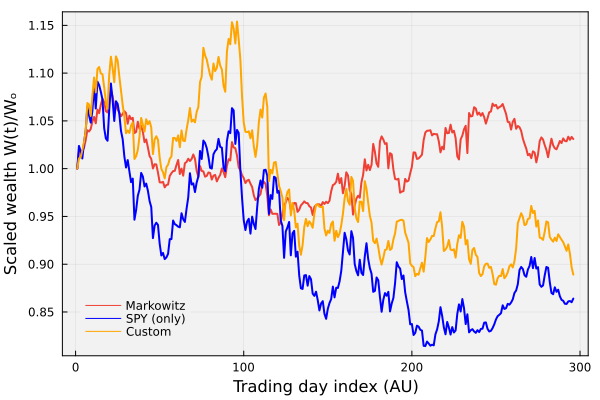

In [17]:
plot(WA/Wₒ, label="Markowitz", legend=:bottomleft, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=2)
plot!(WA_SPY/Wₒ, c=:blue, label="SPY (only)", lw=2)
plot!(WA_custom/Wₒ, c=:orange, label="Custom", lw=2)

# setup axis labels -
xlabel!("Trading day index (AU)", fontsize=18);
ylabel!("Scaled wealth W(t)/Wₒ", fontsize=18)